In [1]:
import pandas as pd
import numpy as np
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
from plotly.graph_objects import * 
import warnings
from sklearn.metrics import mean_absolute_error, r2_score
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing  

from sklearn.model_selection import TimeSeriesSplit


Загрузка данных
=====

In [2]:
df = pd.read_csv('../datatest/monthly-car-sales.csv')

In [3]:
df

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587
...,...,...
103,1968-08,16722
104,1968-09,14385
105,1968-10,21342
106,1968-11,17180


Создадим серию, у которой в качестве индекса будет Month, а в качестве значений - количество продаж Sales

<AxesSubplot:xlabel='Month'>

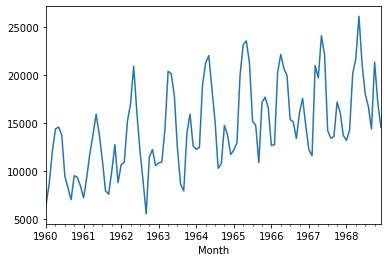

In [4]:
df['Month']=pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)
s = df['Sales']
s.index.freq = 'MS'

s.plot()

Задание №1
===

Разделить данные на train и test, оставив на test два года

In [5]:
train, test = df[0:-24], df[-24:] 

Задание №2
===

* Создать модель <code> SimpleExpSmoothing </code>
* Натренировать ее на train данных
* Сделать предсказания как для train, так и для test
* Выбрать метрики и посчитать качества предсказаний для train и для test
* Построить графики, на которых будут как реальные данные, так и предсказания




In [6]:
metrics_result_table = pd.DataFrame(columns=['Модель', 
                                             'Операция для trend',
                                             'Операция для seasonal',
                                             'MAE на train', 
                                             'MAE на test']) # сюда буду складывать результаты

def modeling (model, picture, metrics): # создаю сразу функцию, так как однотипных построений будет много 
    """
    model: это модель, которую хотим научить
    picture, metrics: bool 
       Не всегда наv интересно смотреть на график или метрики, поэтому если не хотим смотреть что-то из этого - передать False
    """
    model_fit = model.fit()
    predictions_train = model_fit.fittedvalues
    predictions_test = model_fit.forecast(len(test))

    mae_1 = np.round(mean_absolute_error(train, predictions_train), 2)
    mae_2 = np.round(mean_absolute_error(test, predictions_test), 2)

    if picture: # рисовать график, если передаем True
        iplot(Figure(data=[Scatter(x = df.index,
                                   y = df['Sales'],
                                   name = 'Original'),
                           Scatter(x=train.index,
                                   y = predictions_train,
                                   name = 'Predictions_train'),
                           Scatter(x=test.index,
                                   y = predictions_test,
                                   name = 'Predictions_test')]))

    if metrics: # отображать метрики, если передаем True
        print(f'MAE для тренировочных данных {mae_1},\nMAE для тестовых данных {mae_2}')
    
    return mae_1, mae_2 # возвращаем метрики, я их буду в результирующую табличку записывыать


In [7]:
model_ses = SimpleExpSmoothing(train)  

a = modeling(model_ses, picture=True, metrics= True) 

metrics_result_table.loc[len(metrics_result_table.index)] = ['SimpleExpSmoothing', '-', '-', a[0], a[1]]


C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



MAE для тренировочных данных 2463.45,
MAE для тестовых данных 3680.64


Задание №3
===
* Построить модели двойного и тройного экспоненциального сглаживания
* Так же, как и в предыдущем задании, посчитать метрики для train и test
* Построить график

In [8]:
# создаем все модели
model_es2_add = ExponentialSmoothing(train, trend='add') # двойное
model_es2_mul = ExponentialSmoothing(train, trend='mul') # двойное

model_es3_add_add = ExponentialSmoothing(train, trend='add', seasonal='add',seasonal_periods=12) # тройное
model_es3_add_mul = ExponentialSmoothing(train, trend='add', seasonal='mul',seasonal_periods=12) # тройное
model_es3_mul_add = ExponentialSmoothing(train, trend='mul', seasonal='add',seasonal_periods=12) # тройное
model_es3_mul_mul = ExponentialSmoothing(train, trend='mul', seasonal='mul',seasonal_periods=12) # тройное


In [9]:
# тренеруем модели двойного сглаживания, записываем результаты в табличку, строим один из графиков

a = modeling(model_es2_add, picture=True, metrics= True) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['ExponentialSmoothing', 'add', '-', a[0], a[1]]

a = modeling(model_es2_mul, picture=False, metrics= False) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['ExponentialSmoothing', 'mul', '-', a[0], a[1]]




C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



MAE для тренировочных данных 2517.26,
MAE для тестовых данных 4589.74


C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [10]:
# тренеруем модели тройного сглаживания, записываем результаты в табличку, строим самій лучший и самій худший из графиков и смотрим результирующую табличку

a = modeling(model_es3_add_add, picture=True, metrics= True) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['ExponentialSmoothing', 'add', 'add', a[0], a[1]]

a = modeling(model_es3_add_mul, picture=False, metrics= False) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['ExponentialSmoothing', 'add', 'mul', a[0], a[1]]

a = modeling(model_es3_mul_add, picture=True, metrics= True) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['ExponentialSmoothing', 'mul', 'add',  a[0], a[1]]

a = modeling(model_es3_mul_mul, picture=False, metrics= False) 
metrics_result_table.loc[len(metrics_result_table.index)] = ['ExponentialSmoothing', 'mul', 'mul', a[0], a[1]]

metrics_result_table


C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



MAE для тренировочных данных 1013.46,
MAE для тестовых данных 1781.22


C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



MAE для тренировочных данных 11306.82,
MAE для тестовых данных 200409.51


C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



,Модель,Операция для trend,Операция для seasonal,MAE на train,MAE на test
0,SimpleExpSmoothing,-,-,2463.45,3680.64
1,ExponentialSmoothing,add,-,2517.26,4589.74
2,ExponentialSmoothing,mul,-,2504.65,4839.93
3,ExponentialSmoothing,add,add,1013.46,1781.22
4,ExponentialSmoothing,add,mul,1029.25,2223.58
5,ExponentialSmoothing,mul,add,11306.82,200409.51
6,ExponentialSmoothing,mul,mul,1036.53,2473.66


Теперь после сортировки к каждой колонке, можно увидеть, что модель простого сглаживания еще и не самая плохая :-)
Самой удачной буду считать ту, у которой меньше всего ошибка на тесте. 
И наш победитель - аддитивная модель тройного сглаживания. УРА! 

Задание №4
* Выбрать модель с наиболее подходящими параметрами среди предыдущих 
* Сделать цикл кросс-валидации, где размер test равен одному году
* Посчитать среднее значение выбранных метрик

In [11]:
mae_train_list = list()
mae_test_list = list()
test_size = 12
n_splits = 5 
size = len(df)
for i in reversed(range(n_splits)):
    idx = size - (i+1)*test_size
    train_l = s[0:idx]
    test_l = s[idx:idx+test_size]
    rest_l = s[idx+test_size:]
    # print(train_l.shape, test_l.shape)
    model = ExponentialSmoothing(train_l, trend='add', seasonal='add',seasonal_periods=12) # тройное
    model_fit = model.fit()
    predictions_train_l = model_fit.fittedvalues
    predictions_test_l = model_fit.forecast(len(test_l))
    
    
    mae_train_list.append(np.round(mean_absolute_error(train_l, predictions_train_l), 2))
    mae_test_list.append(np.round(mean_absolute_error(test_l, predictions_test_l), 2))


metrics_result_table.loc[len(metrics_result_table.index)] = ['ExponentialSmoothing\cross-validation', 'add', 'add', np.mean(mae_train_list), np.mean(mae_test_list)]
metrics_result_table
   

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



,Модель,Операция для trend,Операция для seasonal,MAE на train,MAE на test
0,SimpleExpSmoothing,-,-,2463.450,3680.640
1,ExponentialSmoothing,add,-,2517.260,4589.740
2,ExponentialSmoothing,mul,-,2504.650,4839.930
3,ExponentialSmoothing,add,add,1013.460,1781.220
4,ExponentialSmoothing,add,mul,1029.250,2223.580
5,ExponentialSmoothing,mul,add,11306.820,200409.510
6,ExponentialSmoothing,mul,mul,1036.530,2473.660
7,ExponentialSmoothing\cross-validation,add,add,993.548,1659.578


Ура! метрика улучшилась довольно хорошо :-)

In [12]:
mae_train_list = list()
mae_test_list = list()

tscv = TimeSeriesSplit(n_splits=5, test_size=12)

for train_index, test_index in tscv.split(df):
    train_l, test_l = df.iloc[train_index], df.iloc[test_index] 
    #print(train_l.shape, test_l.shape)
    
    model = ExponentialSmoothing(train_l, trend='add', seasonal='add',seasonal_periods=12) # тройное
    model_fit = model.fit()
    predictions_train_l = model_fit.fittedvalues
    predictions_test_l = model_fit.forecast(len(test_l))
   
    mae_train_list.append(mean_absolute_error(train_l, predictions_train_l))
    mae_test_list.append(mean_absolute_error(test_l, predictions_test_l))


metrics_result_table.loc[len(metrics_result_table.index)] = ['ExponentialSmoothing\TimeSeriesSplit', 'add', 'add', np.mean(mae_train_list), np.mean(mae_test_list)]
metrics_result_table
   

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



,Модель,Операция для trend,Операция для seasonal,MAE на train,MAE на test
0,SimpleExpSmoothing,-,-,2463.450000,3680.640000
1,ExponentialSmoothing,add,-,2517.260000,4589.740000
2,ExponentialSmoothing,mul,-,2504.650000,4839.930000
3,ExponentialSmoothing,add,add,1013.460000,1781.220000
4,ExponentialSmoothing,add,mul,1029.250000,2223.580000
5,ExponentialSmoothing,mul,add,11306.820000,200409.510000
6,ExponentialSmoothing,mul,mul,1036.530000,2473.660000
7,ExponentialSmoothing\cross-validation,add,add,993.548000,1659.578000
8,ExponentialSmoothing\TimeSeriesSplit,add,add,993.550156,1659.579957


Как и следовало ожидать, метрики почти такие же. 

И вот это "почти" меня как-то поставило в тупик: 
* исходные данные те же
* делю на одинаковые фолды (проверяла на каждой итерации через shape)
* а средняя ошибка отличается

Вобщем в замешательстве... В мою картину мира математики не ложится, короче. 

Буду благодарна за объяснение причины. Спасибо! 